# StackOverflow, performance

Main analysis.

In [1]:
import collabclass
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
with open("../_data/stackoverflow/categories-final.pkl", "rb") as f:
    cats = pickle.load(f)
    
cls2idx = {cls: idx for idx, cls in enumerate(sorted(set(cats.values())))}
k = len(cls2idx)

In [3]:
%%time
with open("../_data/stackoverflow/workspace.pkl", "rb") as f:
    data = pickle.load(f)

user_cnt = 0
item_cnt = 0
user2idx = dict()
item2idx = dict()

edges = list()

for uid, qid, _ in data["edges"]:
    if qid not in cats:
        # We dropped the question -> skip.
        continue
    if qid not in item2idx:
        item2idx[qid] = item_cnt
        item_cnt += 1
    if uid not in user2idx:
        user2idx[uid] = user_cnt
        user_cnt += 1
    edges.append((user2idx[uid], item2idx[qid]))

m = user_cnt
n = item_cnt
    
graph = collabclass.graph_from_edges(m, n, edges)

CPU times: user 16.6 s, sys: 908 ms, total: 17.5 s
Wall time: 17.5 s


In [4]:
print("Number of users:  {:,}".format(m))
print("Number of items:  {:,}".format(n))
print("Number of edges: {:,}".format(len(graph.user_edges)))

Number of users:  644,443
Number of items:  704,982
Number of edges: 2,554,436


In [5]:
idx2item = {v: k for k, v in item2idx.items()}
vs = list()
for j in range(n):
    cat = cats[idx2item[j]]
    vs.append(cls2idx[cat])
vs = np.array(vs)

In [6]:
np.random.seed(0)
vs_hat = collabclass.symmetric_channel(vs, k, delta=0.1)

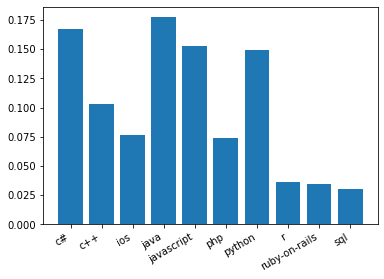

In [7]:
vals, cnts = np.unique(vs, return_counts=True)

fig, ax = plt.subplots()
ax.bar(vals, cnts / cnts.sum());
ax.set_xticks(vals)
ax.set_xticklabels(sorted(set(cats.values())), rotation=30, ha="right");

## CAVI

In [8]:
alpha = np.ones((m, k))
beta = collabclass.init_beta(k, vs_hat, delta=0.30)

In [9]:
%%time
apost, bpost = collabclass.cavi(graph, alpha, beta, 3)
vs_bar = np.argmax(bpost, axis=1)

CPU times: user 5.7 s, sys: 62.8 ms, total: 5.76 s
Wall time: 5.78 s


In [10]:
collabclass.print_accuracy(vs_bar, vs, vs_hat)

accuracy:   0.9542
error rate: 0.0458
FP rate:    0.0110
FN rate:    0.3574


In [11]:
collabclass.degree_breakdown(vs_bar, vs, graph, qs=(50, 90, 98))

accuracy at 50th percentile (d ≥ 3): 0.9629
accuracy at 90th percentile (d ≥ 6): 0.9697
accuracy at 98th percentile (d ≥ 10): 0.9723


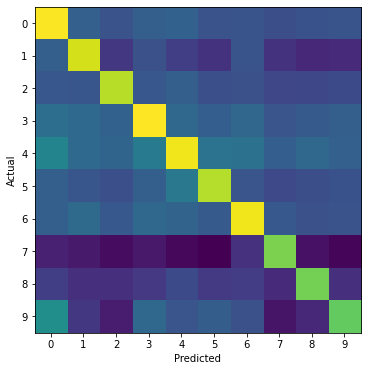

In [12]:
collabclass.confusion_matrix(vs_bar, vs);

What about if we "loosen" the criterion a bit and look at the top-2 classes?

In [13]:
collabclass.degree_breakdown_topk(bpost, vs, graph, k=2)

top-2 accuracy at 0th percentile (d ≥ 1): 0.9861
top-2 accuracy at 50th percentile (d ≥ 3): 0.9906
top-2 accuracy at 90th percentile (d ≥ 6): 0.9930
top-2 accuracy at 95th percentile (d ≥ 8): 0.9936


## wvRN

In [14]:
%%time
vs_bar = collabclass.wvrn(graph, vs_hat)

CPU times: user 374 ms, sys: 20.4 ms, total: 394 ms
Wall time: 393 ms


In [15]:
collabclass.print_accuracy(vs_bar, vs, vs_hat)

accuracy:   0.8147
error rate: 0.1853
FP rate:    0.1840
FN rate:    0.1973


In [16]:
collabclass.degree_breakdown(vs_bar, vs, graph, qs=(50, 90, 95, 99))

accuracy at 50th percentile (d ≥ 3): 0.8431
accuracy at 90th percentile (d ≥ 6): 0.8505
accuracy at 95th percentile (d ≥ 8): 0.8528
accuracy at 99th percentile (d ≥ 12): 0.8531


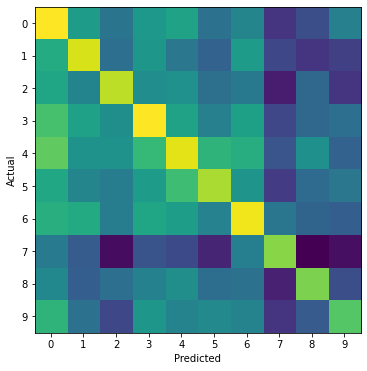

In [17]:
collabclass.confusion_matrix(vs_bar, vs);

## Deep dive into errors of CAVI

In [18]:
res = np.argsort(bpost, axis=1)[:,::-1]
mistakes = ((res[:,0] != vs) & (res[:,1] != vs))
not_corrupted = (vs_hat == vs)
high_degree = (graph.item_idx[:,1] >= 10)

idx2cls = {v: k for k, v in cls2idx.items()}

for idx in np.argwhere(mistakes & not_corrupted & high_degree).ravel()[:10]:
    print("---")
    print(f"Actual: {idx2cls[vs[idx]]}, predicted: {idx2cls[vs_bar[idx]]}")
    print(f"URL: https://stackoverflow.com/questions/{idx2item[idx]}")

---
Actual: sql, predicted: c#
URL: https://stackoverflow.com/questions/11043
---
Actual: sql, predicted: c#
URL: https://stackoverflow.com/questions/31057
---
Actual: sql, predicted: java
URL: https://stackoverflow.com/questions/64749
---
Actual: php, predicted: python
URL: https://stackoverflow.com/questions/91618
---
Actual: java, predicted: c++
URL: https://stackoverflow.com/questions/99164
---
Actual: ruby-on-rails, predicted: sql
URL: https://stackoverflow.com/questions/159087
---
Actual: javascript, predicted: c#
URL: https://stackoverflow.com/questions/173070
---
Actual: ruby-on-rails, predicted: java
URL: https://stackoverflow.com/questions/183462
---
Actual: php, predicted: c#
URL: https://stackoverflow.com/questions/218264
---
Actual: sql, predicted: php
URL: https://stackoverflow.com/questions/276927
